In [1]:
import os
import pickle

# # import pickle file 
with open('scenario-properties-test.pkl', 'rb') as f:
    baseline = pickle.load(f)

# with open('scenario-properties-dv.pkl', 'rb') as f:
#     dv = pickle.load(f)

KeyboardInterrupt: 

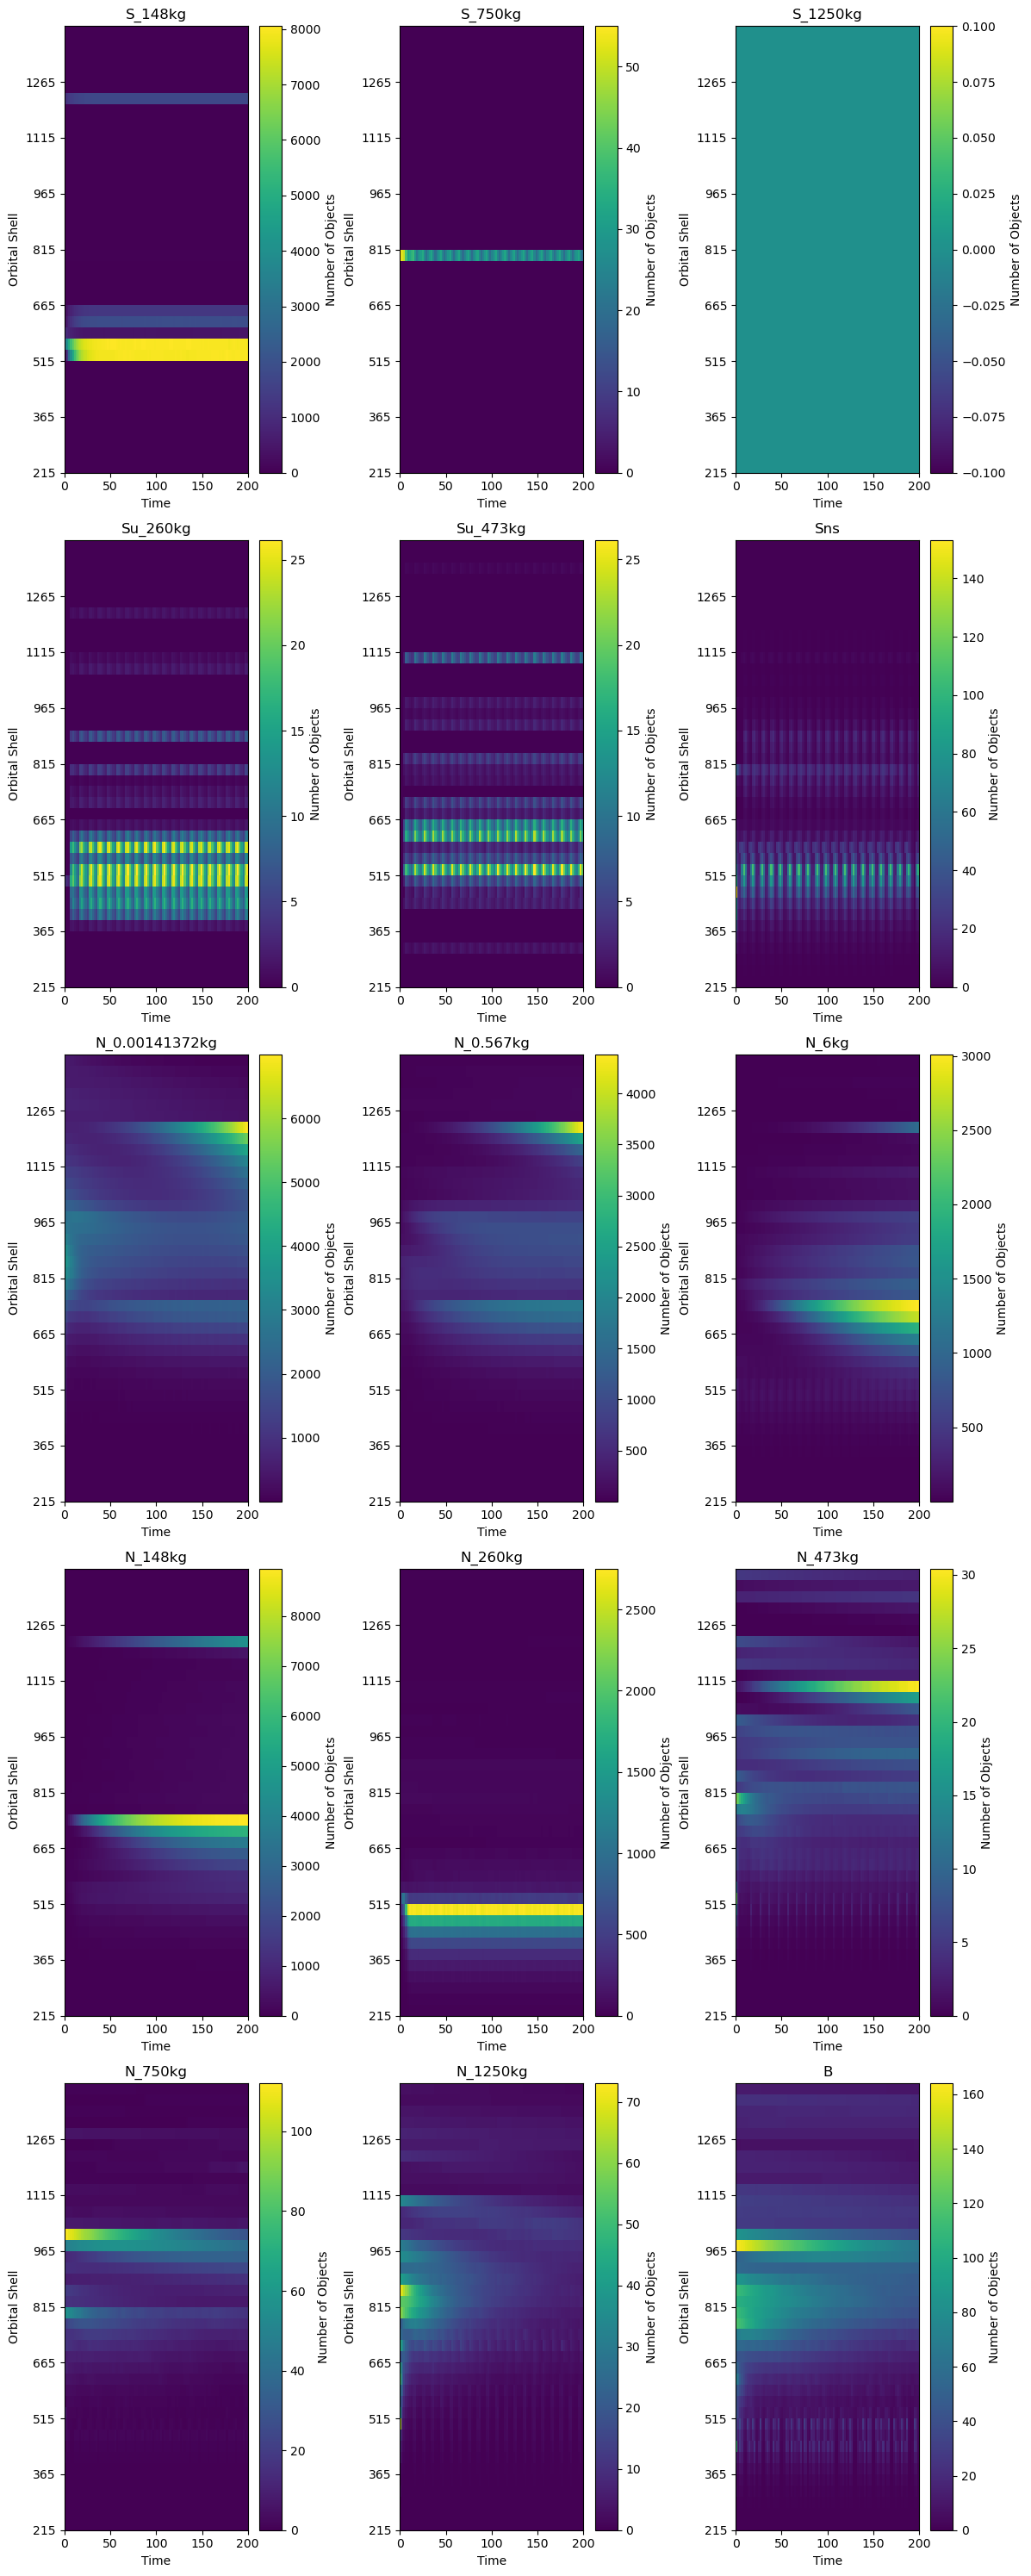

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

scenario_properties = baseline
output = scenario_properties.output
os.makedirs('figures', exist_ok=True)

# Plot each species across all shells
n_species = scenario_properties.species_length
num_shells = scenario_properties.n_shells

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for species_index in range(n_species):
    ax = axes.flatten()[species_index]
    species_data = output.y[species_index * num_shells:(species_index + 1) * num_shells]

    for shell_index in range(num_shells):
        ax.plot(output.t, species_data[shell_index], label=f'Shell {shell_index + 1}')

    total = np.sum(species_data, axis=0)
    ax.set_title(f'{scenario_properties.species_names[species_index]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.suptitle('Species 1 All Shells')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures/species_all_shells.png')
plt.close(fig)

# Plot total objects over time for each species and total
species_names = scenario_properties.species_names
plt.figure(figsize=(10, 6))

total_objects_all_species = np.zeros_like(output.t)

for i in range(n_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    total_objects_all_species += total_objects_per_species

plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
plt.legend()
plt.tight_layout()
plt.savefig('figures/total_objects_over_time.png')
plt.close()

# Plot heatmap for each species
n_time_points = len(output["t"])
cols = 3
rows = np.ceil(n_species / cols).astype(int)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6))
for i, species_name in enumerate(species_names):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]

    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]

    cax = ax.imshow(data_per_species, aspect='auto', origin='lower',
                    extent=[output["t"][0], output["t"][-1], 0, num_shells],
                    interpolation='nearest')
    fig.colorbar(cax, ax=ax, label='Number of Objects')
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_title(species_name)
    ax.set_xticks(np.linspace(output["t"][0], output["t"][-1], num=5))
    ax.set_yticks(np.arange(0, num_shells, 5))
    ax.set_yticklabels([f'{alt:.0f}' for alt in scenario_properties.HMid[::5]])

for i in range(n_species, rows * cols):
    if rows == 1:
        fig.delaxes(axs[i])
    else:
        axs.flatten()[i].set_visible(False)

plt.tight_layout()
plt.savefig('figures/heatmaps_species.png')
plt.close(fig)

time_points = output.t

n_species = scenario_properties.species_length
shells_per_species = scenario_properties.n_shells

# Get the species names
species_names = scenario_properties.species_names

# Extract the unique base species names (part before the underscore)
base_species_names = [name.split('_')[0] for name in species_names]
unique_base_species = list(set(base_species_names))

# Extract weights from species names
def extract_weight(name):
    try:
        return float(name.split('_')[1].replace('kg', ''))
    except (IndexError, ValueError):
        return 0

weights = [extract_weight(name) for name in species_names]

# Normalize weights to range [0, 1] for color shading and invert to make lower weights darker
max_weight = max(weights)
min_weight = min(weights)
normalized_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]
inverted_weights = [1 - nw for nw in normalized_weights]

# Create a color map for the base species
color_map = plt.cm.get_cmap('tab20', len(unique_base_species))

# Reshape the data to separate species and shells
n_time_points = len(time_points)
data_reshaped = output.y.reshape(n_species, shells_per_species, n_time_points)

# Get the x-axis labels from scenario_properties.R0_km and slice to match shells_per_species
orbital_shell_labels = scenario_properties.R0_km[:shells_per_species]

# Define markers for each species (reuse if more species than markers)
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']

# Directory to save the frames
frames_dir = 'frames'
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Generate frames for each timestep
for t_idx, t in enumerate(time_points):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))  # Adjust the size as needed
    
    # Plot species names that begin with 'S' on the left plot
    for species_index in range(n_species):
        if base_species_names[species_index].startswith('S'):
            base_color = color_map(unique_base_species.index(base_species_names[species_index]))
            color = (base_color[0], base_color[1], base_color[2], inverted_weights[species_index])  # Adjust alpha based on inverted weight
            marker = markers[species_index % len(markers)]
            ax1.plot(orbital_shell_labels, data_reshaped[species_index, :, t_idx], label=species_names[species_index], color=color, marker=marker)
    
    # Setting titles and labels for the left plot
    ax1.set_title('Final Timestep: Species Starting with S')
    ax1.set_xlabel('Orbital Shell (R0_km)')
    ax1.set_ylabel('Count of Objects')
    ax1.legend(title='Species')
    
    # Plot the rest of the species on the right plot
    for species_index in range(n_species):
        if not base_species_names[species_index].startswith('S'):
            base_color = color_map(unique_base_species.index(base_species_names[species_index]))
            color = (base_color[0], base_color[1], base_color[2], inverted_weights[species_index])  # Adjust alpha based on inverted weight
            marker = markers[species_index % len(markers)]
            ax2.plot(orbital_shell_labels, data_reshaped[species_index, :, t_idx], label=species_names[species_index], color=color, marker=marker)
    
    # Setting titles and labels for the right plot
    ax2.set_title('Final Timestep: Other Species')
    ax2.set_xlabel('Orbital Shell (R0_km)')
    ax2.set_ylabel('Count of Objects')
    ax2.legend(title='Species')
    
    plt.tight_layout()
    
    # Save the frame
    frame_path = os.path.join(frames_dir, f'frame_{t_idx:04d}.png')
    plt.savefig(frame_path)
    plt.close(fig)

# Create the GIF
images = []
for t_idx in range(len(time_points)):
    frame_path = os.path.join(frames_dir, f'frame_{t_idx:04d}.png')
    images.append(imageio.imread(frame_path))
gif_path = 'figures/species_shells_evolution_side_by_side.gif'
imageio.mimsave(gif_path, images, duration=0.5)  # Adjust the duration as needed

# Cleanup frames
import shutil
shutil.rmtree(frames_dir)

In [ ]:
species_masses = []
for species_group in scenario_properties.species.values():
    for species in species_group:
        species_masses.append(species.mass)


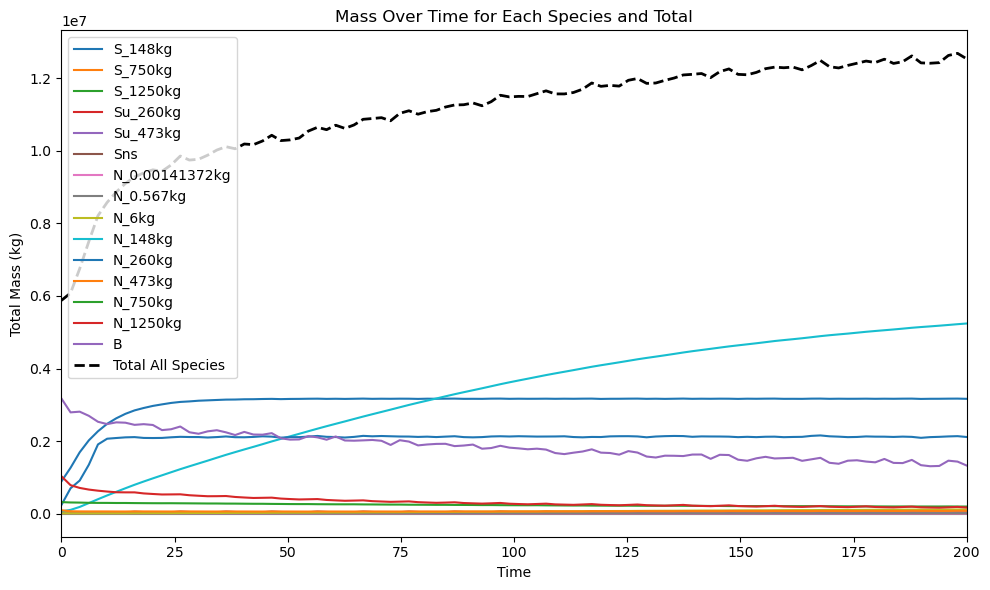

In [26]:
species_names = scenario_properties.species_names
species_masses = []
for species_group in scenario_properties.species.values():
    for species in species_group:
        species_masses.append(species.mass)  # Collect masses in order of species

plt.figure(figsize=(10, 6))
total_mass_all_species = np.zeros_like(output.t)

# Loop through species and calculate the mass for each species
for i in range(n_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    
    # Calculate the total object count for the current species
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)
    
    # Use the species mass by indexing the species_masses list directly
    species_mass = species_masses[i]
    
    # Multiply the object count by the species mass to get total mass
    total_mass_per_species = total_objects_per_species * species_mass
    
    # Plot the total mass for the current species
    plt.plot(output.t, total_mass_per_species, label=f'{species_names[i]}')
    
    # Sum the total mass for all species
    total_mass_all_species += total_mass_per_species

# Plot the total mass for all species combined
plt.plot(output.t, total_mass_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Total Mass (kg)')
plt.title('Mass Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
plt.legend()
plt.tight_layout()
plt.show()

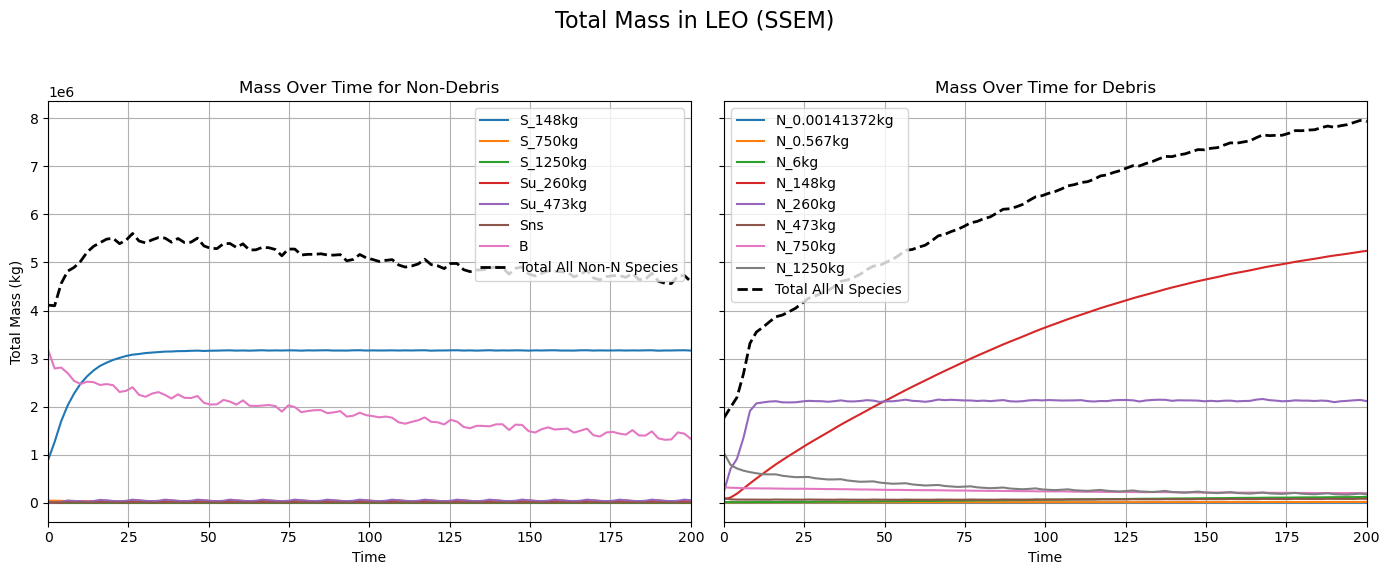

In [30]:
species_names = scenario_properties.species_names
species_masses = []
for species_group in scenario_properties.species.values():
    for species in species_group:
        species_masses.append(species.mass)  # Collect masses in order of species

# Create two subplots: one for species that don't start with 'N', and one for species that do
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

total_mass_all_species_left = np.zeros_like(output.t)
total_mass_all_species_right = np.zeros_like(output.t)

# Loop through species and calculate the mass for each species
for i in range(n_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    
    # Calculate the total object count for the current species
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)
    
    # Use the species mass by indexing the species_masses list directly
    species_mass = species_masses[i]
    
    # Multiply the object count by the species mass to get total mass
    total_mass_per_species = total_objects_per_species * species_mass
    
    # Plot on the left subplot if species does NOT start with 'N', otherwise plot on the right
    if species_names[i].startswith('N'):
        ax2.plot(output.t, total_mass_per_species, label=f'{species_names[i]}')
        total_mass_all_species_right += total_mass_per_species
    else:
        ax1.plot(output.t, total_mass_per_species, label=f'{species_names[i]}')
        total_mass_all_species_left += total_mass_per_species

# Plot the total mass for all species on each subplot
ax1.plot(output.t, total_mass_all_species_left, label='Total All Non-N Species', color='k', linewidth=2, linestyle='--')
ax2.plot(output.t, total_mass_all_species_right, label='Total All N Species', color='k', linewidth=2, linestyle='--')

# Customize the left plot (Non-'N' species)
ax1.set_title('Mass Over Time for Non-Debris')
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Mass (kg)')
ax1.set_xlim(0, max(output.t))
# ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Customize the right plot ('N' species)
ax2.set_title('Mass Over Time for Debris')
ax2.set_xlabel('Time')
ax2.set_xlim(0, max(output.t))
ax2.legend()
# ax2.set_yscale('log')

ax2.grid(True)

# Add an overall title for both subplots
fig.suptitle('Total Mass in LEO (SSEM)', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()